<a href="https://colab.research.google.com/github/nagolinc/notebooks/blob/main/Grokking_Stable_Diffusion_%5Bwith_CLIP_loss%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grokking Stable Diffusion

I've been playing with stable diffusion (who hasn't) and starting to think about how to structure learning material about diffusion models. This notebook is basically a tidier version of my first dabble with the model, trying to understand ('grok') the individual parts and to think about how they could be presented as part of a lesson. 

This will eventually turn into a more polished component of a larger course (announcement soon!), but I can't resist sharing this now for everyone else trying to hack around with this cool new toy. Feel free to contact me @johnowhitaker with questions or join the AIAIART discord (link is in the readme of https://github.com/johnowhitaker/aiaiart) where we'll chat about this (and maybe do a video walkthrough in a few days).

OK enough intro, have fun and happy hacking :)

## Setup & Imports

Here we install the library, log into HF (you'll need to accept the licence terms to download the model) and import some things we'll need for the demos.

In [1]:
!pip install transformers diffusers lpips 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#from huggingface_hub import notebook_login
#notebook_login()

In [3]:
hf_token=<your token here>
from huggingface_hub.commands.user import _login
from huggingface_hub.hf_api import HfApi, HfFolder
_login(HfApi(), token=hf_token)

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). 

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.12.mlp.fc2.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.layer_norm1.weight', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.enco

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

## Guidance

OK, the bit you've been waiting for! How can we add some extra control to this generation process?

At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image. 

THis function can be anything, but let's demo with a super simple example. If we want images that have a lot of blue, we can craft a loss function that gives a high loss if pixels have a low blue component:

In [7]:
def blue_loss(images):
  # How far are the blue channel values to 0.9:
  error = torch.abs(images[:,-1, :, :] - 0.9).mean() 
  return error

Inspect the code below to see how I've added this (specifically, the `ADDITIONAL GUIDANCE` section of the loop). Run this and then let's talk about what's happening.

In [8]:
#@title Store the predicted outputs and next frame for later viewing
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 40 #@param

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

do_this=False

if do_this:
  # Prep text 
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  # Prep Scheduler
  scheduler.set_timesteps(num_inference_steps)

  # Prep latents
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.sigmas[0] # Need to scale to match k

  # Loop
  with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
      
      #### ADDITIONAL GUIDANCE ###
      # Requires grad on the latents
      latents = latents.detach().requires_grad_()

      # Get the predicted x0:
      latents_x0 = latents - sigma * noise_pred

      # Decode to image space
      denoised_images = vae.decode((1 / 0.18215) * latents_x0) / 2 + 0.5 # (0, 1)

      # Calculate loss
      loss = blue_loss(denoised_images) * blue_loss_scale
      if i%10==0:
        print(i, 'loss:', loss.item())

      # Get gradient
      cond_grad = -torch.autograd.grad(loss, latents)[0]

      # Modify the latents based on this gradient
      latents = latents.detach() + cond_grad * sigma**2
      

      ### And saving as before ###
      # Get the predicted x0:
      latents_x0 = latents - sigma * noise_pred
      im_t0 = latents_to_pil(latents_x0)[0]

      # And the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
      im_next = latents_to_pil(latents)[0]

      # Combine the two images and save for later viewing
      im = Image.new('RGB', (1024, 512))
      im.paste(im_next, (0, 0))
      im.paste(im_t0, (512, 0))
      im.save(f'steps/{i:04}.jpeg')

  latents_to_pil(latents)[0]

Here's what the output looks like for a few different `blue_loss_scale` valuess:

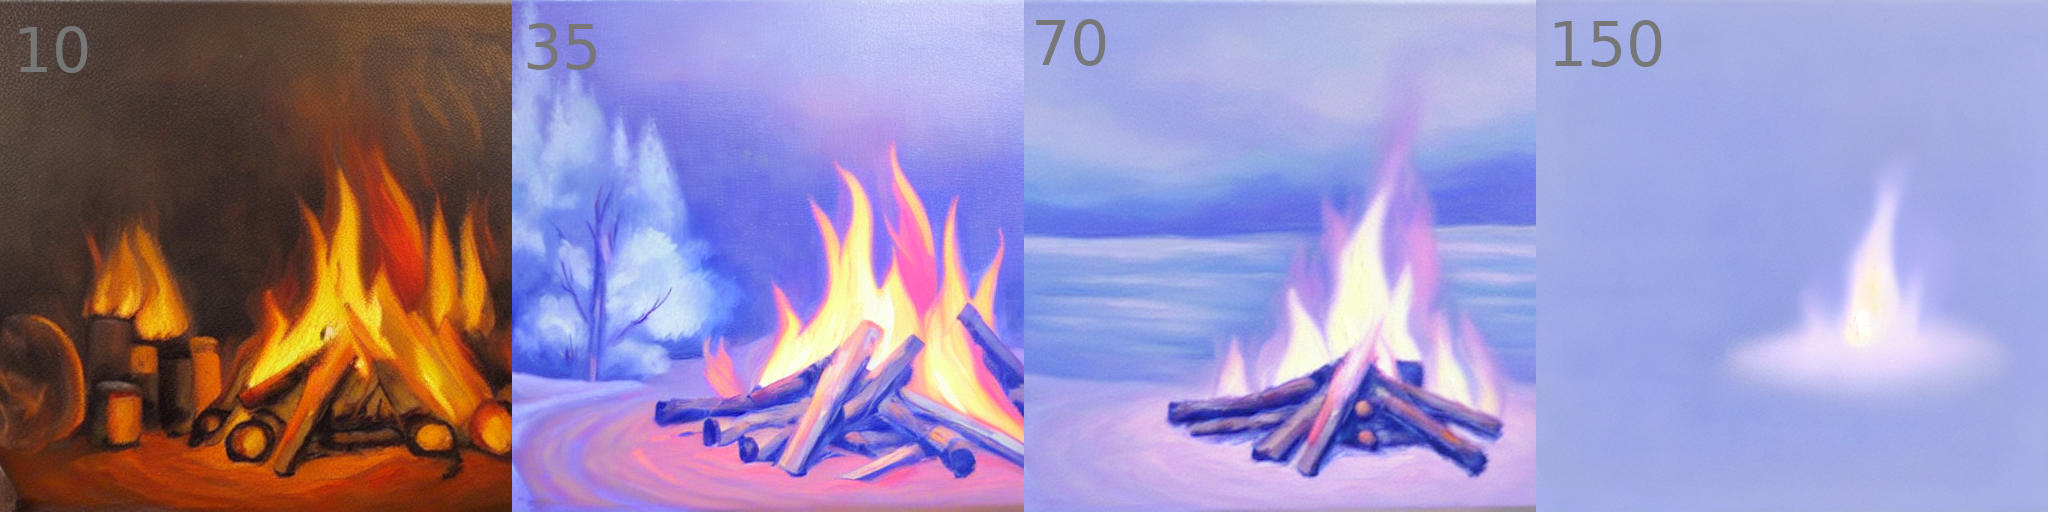

This prompt really doesn't want to be blue, so I had to set the scale quite high. Lower (eg 10) or remove it to check for yourself that this is definitely having an effect on the output - without this extra loss we'd something red/orange and dark. Set it higher (100 or 200) and it starts to overwhelm the process.

How is this working?

The key here:
- We find our predicted output image
- We find our loss based on this
- We get the gradient of this loss WITH RESPECT TO OUR X (the latents)
- We modify the current X based on this gradient

This is 'nudging' the output at each step in a way that reduces our loss. We can control this by scaling the loss (too high and it takes over, too low and it won't affect the process much).

In this example we're finding the loss in image space, which means we need to decode the latents every step and trace gradients back through the AE's decoder. Hence it's pretty slow. At the moment, this is necessary for things like CLIP guidance, perceptual similarity etc. But with a bit of effort we could probably train models that operate directly on these latents for much faster guidance! 

I leave it to you dear reader to fill in a more interesting loss function here. Imagine:

`loss = style_loss + perceptual_loss + masked_color_palette_complexity_loss + does_it_look_like_a_fish_loss + similarity_to_elvis + ...`

You get the idea :)

# Conclusions

This is a neat model, and there is a lot we can do with it! I hope this notebook helped you peek under the hood a little more, and that you're inspired to start exploring further and doing some experiments of your own. If you have questions, you can find me on twitter @johnowhitaker or come and join our AIAIART discord (invite link at the bottom of the readme here: https://github.com/johnowhitaker/aiaiart). I'll be announcing a new course soon, so stay tuned for an announcement on that shortly too :)

### PS: This notebook uses a fixed seed for some demos, if you don't want this remove `generator=generator` from anywhere noise is being generated...

# Copy a bunch of stuff from disco diffusion

In [9]:
#@title 1.2 Prepare Folders
import subprocess, os, sys, ipykernel

def gitclone(url, targetdir=None):
    if targetdir:
        res = subprocess.run(['git', 'clone', url, targetdir], stdout=subprocess.PIPE).stdout.decode('utf-8')
    else:
        res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipi(modulestr):
    res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipie(modulestr):
    res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def wget(url, outputdir):
    res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

try:
    from google.colab import drive
    print("Google Colab detected. Using Google Drive.")
    is_colab = True
    #@markdown If you connect your Google Drive, you can save the final image of each run on your drive.
    google_drive = True #@param {type:"boolean"}
    #@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
    save_models_to_google_drive = True #@param {type:"boolean"}
    print("Downgrading ipywidgets to latest 7.x in order to enable custom widget manager (for tqdm progress bars)")
    multipip_res = subprocess.run(['pip', 'install', 'ipywidgets>=7,<8'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(multipip_res)
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    is_colab = False
    google_drive = False
    save_models_to_google_drive = False
    print("Google Colab not detected.")

if is_colab:
    if google_drive is True:
        drive.mount('/content/drive')
        root_path = '/content/drive/MyDrive/AI/Disco_Diffusion'
    else:
        root_path = '/content'
else:
    root_path = os.getcwd()

import os
def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

initDirPath = f'{root_path}/init_images'
createPath(initDirPath)
outDirPath = f'{root_path}/images_out'
createPath(outDirPath)

if is_colab:
    if google_drive and not save_models_to_google_drive or not google_drive:
        model_path = '/content/models'
        createPath(model_path)
    if google_drive and save_models_to_google_drive:
        model_path = f'{root_path}/models'
        createPath(model_path)
else:
    model_path = f'{root_path}/models'
    createPath(model_path)

# libraries = f'{root_path}/libraries'
# createPath(libraries)

Google Colab detected. Using Google Drive.
Downgrading ipywidgets to latest 7.x in order to enable custom widget manager (for tqdm progress bars)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Mounted at /content/drive


In [10]:
#@title ### 1.3 Install, import dependencies and set up runtime devices

import pathlib, shutil, os, sys

# There are some reports that with a T4 or V100 on Colab, downgrading to a previous version of PyTorch may be necessary.
# .. but there are also reports that downgrading breaks them!  If you're facing issues, you may want to try uncommenting and running this code.
# nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
# cards_requiring_downgrade = ["Tesla T4", "V100"]
# if is_colab:
#     if any(cardstr in nvidiasmi_output for cardstr in cards_requiring_downgrade):
#         print("Downgrading pytorch. This can take a couple minutes ...")
#         downgrade_pytorch_result = subprocess.run(['pip', 'install', 'torch==1.10.2', 'torchvision==0.11.3', '-q'], stdout=subprocess.PIPE).stdout.decode('utf-8')
#         print("pytorch downgraded.")

#@markdown Check this if you want to use CPU
useCPU = False #@param {type:"boolean"}

if not is_colab:
    # If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
    os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

PROJECT_DIR = os.path.abspath(os.getcwd())
USE_ADABINS = True

if is_colab:
    if not google_drive:
        root_path = f'/content'
        model_path = '/content/models' 
else:
    root_path = os.getcwd()
    model_path = f'{root_path}/models'

multipip_res = subprocess.run(['pip', 'install', 'lpips', 'datetime', 'timm', 'ftfy', 'einops', 'pytorch-lightning', 'omegaconf'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(multipip_res)

if is_colab:
    subprocess.run(['apt', 'install', 'imagemagick'], stdout=subprocess.PIPE).stdout.decode('utf-8')

try:
    from CLIP import clip
except:
    if not os.path.exists("CLIP"):
        gitclone("https://github.com/openai/CLIP")
    sys.path.append(f'{PROJECT_DIR}/CLIP')

try:
    import open_clip
except:
    if not os.path.exists("open_clip/src"):
        gitclone("https://github.com/mlfoundations/open_clip.git")
    sys.path.append(f'{PROJECT_DIR}/open_clip/src')
    import open_clip

try:
    from guided_diffusion.script_util import create_model_and_diffusion
except:
    if not os.path.exists("guided-diffusion"):
        gitclone("https://github.com/kostarion/guided-diffusion")
    sys.path.append(f'{PROJECT_DIR}/guided-diffusion')

try:
    from resize_right import resize
except:
    if not os.path.exists("ResizeRight"):
        gitclone("https://github.com/assafshocher/ResizeRight.git")
    sys.path.append(f'{PROJECT_DIR}/ResizeRight')

try:
    import py3d_tools
except:
    if not os.path.exists('pytorch3d-lite'):
        gitclone("https://github.com/MSFTserver/pytorch3d-lite.git")
    sys.path.append(f'{PROJECT_DIR}/pytorch3d-lite')

try:
    from midas.dpt_depth import DPTDepthModel
except:
    if not os.path.exists('MiDaS'):
        gitclone("https://github.com/isl-org/MiDaS.git")
    if not os.path.exists('MiDaS/midas_utils.py'):
        shutil.move('MiDaS/utils.py', 'MiDaS/midas_utils.py')
    if not os.path.exists(f'{model_path}/dpt_large-midas-2f21e586.pt'):
        wget("https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt", model_path)
    sys.path.append(f'{PROJECT_DIR}/MiDaS')

try:
    sys.path.append(PROJECT_DIR)
    import disco_xform_utils as dxf
except:
    if not os.path.exists("disco-diffusion"):
        gitclone("https://github.com/alembics/disco-diffusion.git")
    if not os.path.exists('disco_xform_utils.py'):
        shutil.move('disco-diffusion/disco_xform_utils.py', 'disco_xform_utils.py')
    sys.path.append(PROJECT_DIR)

import torch
from dataclasses import dataclass
from functools import partial
import cv2
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
from resize_right import resize
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib
from functools import partial
if is_colab:
    os.chdir('/content')
    from google.colab import files
else:
    os.chdir(f'{PROJECT_DIR}')
from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# AdaBins stuff
if USE_ADABINS:
    try:
        from infer import InferenceHelper
    except:
        if not os.path.exists("AdaBins"):
            gitclone("https://github.com/shariqfarooq123/AdaBins.git")
        if not os.path.exists(f'{PROJECT_DIR}/pretrained/AdaBins_nyu.pt'):
            createPath(f'{PROJECT_DIR}/pretrained')
            wget("https://cloudflare-ipfs.com/ipfs/Qmd2mMnDLWePKmgfS8m6ntAg4nhV5VkUyAydYBp8cWWeB7/AdaBins_nyu.pt", f'{PROJECT_DIR}/pretrained')
        sys.path.append(f'{PROJECT_DIR}/AdaBins')
    from infer import InferenceHelper
    MAX_ADABINS_AREA = 500000

import torch
DEVICE = torch.device('cuda:0' if (torch.cuda.is_available() and not useCPU) else 'cpu')
print('Using device:', DEVICE)
device = DEVICE # At least one of the modules expects this name..

if not useCPU:
    if torch.cuda.get_device_capability(DEVICE) == (8,0): ## A100 fix thanks to Emad
        print('Disabling CUDNN for A100 gpu', file=sys.stderr)
        torch.backends.cudnn.enabled = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=e27a2cda5c032d898c2ae5d664300d1a08bead327c9a70e79d2314a27e2f6a2e
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0










Using device: cuda:0


In [11]:
#@title ### 1.4 Define Midas functions

from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet

# Initialize MiDaS depth model.
# It remains resident in VRAM and likely takes around 2GB VRAM.
# You could instead initialize it for each frame (and free it after each frame) to save VRAM.. but initializing it is slow.
default_models = {
    "midas_v21_small": f"{model_path}/midas_v21_small-70d6b9c8.pt",
    "midas_v21": f"{model_path}/midas_v21-f6b98070.pt",
    "dpt_large": f"{model_path}/dpt_large-midas-2f21e586.pt",
    "dpt_hybrid": f"{model_path}/dpt_hybrid-midas-501f0c75.pt",
    "dpt_hybrid_nyu": f"{model_path}/dpt_hybrid_nyu-2ce69ec7.pt",}


def init_midas_depth_model(midas_model_type="dpt_large", optimize=True):
    midas_model = None
    net_w = None
    net_h = None
    resize_mode = None
    normalization = None

    print(f"Initializing MiDaS '{midas_model_type}' depth model...")
    # load network
    midas_model_path = default_models[midas_model_type]

    if midas_model_type == "dpt_large": # DPT-Large
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitl16_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid": #DPT-Hybrid
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid_nyu": #DPT-Hybrid-NYU
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "midas_v21":
        midas_model = MidasNet(midas_model_path, non_negative=True)
        net_w, net_h = 384, 384
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    elif midas_model_type == "midas_v21_small":
        midas_model = MidasNet_small(midas_model_path, features=64, backbone="efficientnet_lite3", exportable=True, non_negative=True, blocks={'expand': True})
        net_w, net_h = 256, 256
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    else:
        print(f"midas_model_type '{midas_model_type}' not implemented")
        assert False

    midas_transform = T.Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method=resize_mode,
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

    midas_model.eval()
    
    if optimize==True:
        if DEVICE == torch.device("cuda"):
            midas_model = midas_model.to(memory_format=torch.channels_last)  
            midas_model = midas_model.half()

    midas_model.to(DEVICE)

    print(f"MiDaS '{midas_model_type}' depth model initialized.")
    return midas_model, midas_transform, net_w, net_h, resize_mode, normalization

In [12]:
#@title 1.5 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

import py3d_tools as p3dT
import disco_xform_utils as dxf

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

def regen_perlin():
    if perlin_mode == 'color':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == 'gray':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)

    init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
    del init2
    return init.expand(batch_size, -1, -1, -1)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(self.cutn):
            if ch > self.cutn - self.cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts

cutout_debug = False
padargs = {}

class MakeCutoutsDango(nn.Module):
    def __init__(self, cut_size,
                 Overview=4, 
                 InnerCrop = 0, IC_Size_Pow=0.5, IC_Grey_P = 0.2
                 ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        if args.animation_mode == 'None':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif args.animation_mode == 'Video Input':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomPerspective(distortion_scale=0.4, p=0.7),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.15),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif  args.animation_mode == '2D' or args.animation_mode == '3D':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.4),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.3),
          ])
          

    def forward(self, input):
        cutouts = []
        gray = T.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [1,3,self.cut_size,self.cut_size] 
        output_shape_2 = [1,3,self.cut_size+2,self.cut_size+2]
        pad_input = F.pad(input,((sideY-max_size)//2,(sideY-max_size)//2,(sideX-max_size)//2,(sideX-max_size)//2), **padargs)
        cutout = resize(pad_input, out_shape=output_shape)

        if self.Overview>0:
            if self.Overview<=4:
                if self.Overview>=1:
                    cutouts.append(cutout)
                if self.Overview>=2:
                    cutouts.append(gray(cutout))
                if self.Overview>=3:
                    cutouts.append(TF.hflip(cutout))
                if self.Overview==4:
                    cutouts.append(gray(TF.hflip(cutout)))
            else:
                cutout = resize(pad_input, out_shape=output_shape)
                for _ in range(self.Overview):
                    cutouts.append(cutout)

            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("/content/cutout_overview0.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("cutout_overview0.jpg",quality=99)

                              
        if self.InnerCrop >0:
            for i in range(self.InnerCrop):
                size = int(torch.rand([])**self.IC_Size_Pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                if i <= int(self.IC_Grey_P * self.InnerCrop):
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("/content/cutout_InnerCrop.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("cutout_InnerCrop.jpg",quality=99)
        cutouts = torch.cat(cutouts)
        if skip_augs is not True: cutouts=self.augs(cutouts)
        return cutouts

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)     

def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete
TRANSLATION_SCALE = 1.0/200.0

def do_3d_step(img_filepath, frame_num, midas_model, midas_transform):
  if args.key_frames:
    translation_x = args.translation_x_series[frame_num]
    translation_y = args.translation_y_series[frame_num]
    translation_z = args.translation_z_series[frame_num]
    rotation_3d_x = args.rotation_3d_x_series[frame_num]
    rotation_3d_y = args.rotation_3d_y_series[frame_num]
    rotation_3d_z = args.rotation_3d_z_series[frame_num]
    print(
        f'translation_x: {translation_x}',
        f'translation_y: {translation_y}',
        f'translation_z: {translation_z}',
        f'rotation_3d_x: {rotation_3d_x}',
        f'rotation_3d_y: {rotation_3d_y}',
        f'rotation_3d_z: {rotation_3d_z}',
    )

  translate_xyz = [-translation_x*TRANSLATION_SCALE, translation_y*TRANSLATION_SCALE, -translation_z*TRANSLATION_SCALE]
  rotate_xyz_degrees = [rotation_3d_x, rotation_3d_y, rotation_3d_z]
  print('translation:',translate_xyz)
  print('rotation:',rotate_xyz_degrees)
  rotate_xyz = [math.radians(rotate_xyz_degrees[0]), math.radians(rotate_xyz_degrees[1]), math.radians(rotate_xyz_degrees[2])]
  rot_mat = p3dT.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
  print("rot_mat: " + str(rot_mat))
  next_step_pil = dxf.transform_image_3d(img_filepath, midas_model, midas_transform, DEVICE,
                                          rot_mat, translate_xyz, args.near_plane, args.far_plane,
                                          args.fov, padding_mode=args.padding_mode,
                                          sampling_mode=args.sampling_mode, midas_weight=args.midas_weight)
  return next_step_pil

def symmetry_transformation_fn(x):
    if args.use_horizontal_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat((x[:, :, :, :w//2], torch.flip(x[:, :, :, :w//2], [-1])), -1)
        print("horizontal symmetry applied")
    if args.use_vertical_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat((x[:, :, :h//2, :], torch.flip(x[:, :, :h//2, :], [-2])), -2)
        print("vertical symmetry applied")
    return x

def do_run():
  seed = args.seed
  print(range(args.start_frame, args.max_frames))

  if (args.animation_mode == "3D") and (args.midas_weight > 0.0):
      midas_model, midas_transform, midas_net_w, midas_net_h, midas_resize_mode, midas_normalization = init_midas_depth_model(args.midas_depth_model)
  for frame_num in range(args.start_frame, args.max_frames):
      if stop_on_next_loop:
        break
      
      display.clear_output(wait=True)

      # Print Frame progress if animation mode is on
      if args.animation_mode != "None":
        batchBar = tqdm(range(args.max_frames), desc ="Frames")
        batchBar.n = frame_num
        batchBar.refresh()

      
      # Inits if not video frames
      if args.animation_mode != "Video Input":
        if args.init_image in ['','none', 'None', 'NONE']:
          init_image = None
        else:
          init_image = args.init_image
        init_scale = args.init_scale
        skip_steps = args.skip_steps

      if args.animation_mode == "2D":
        if args.key_frames:
          angle = args.angle_series[frame_num]
          zoom = args.zoom_series[frame_num]
          translation_x = args.translation_x_series[frame_num]
          translation_y = args.translation_y_series[frame_num]
          print(
              f'angle: {angle}',
              f'zoom: {zoom}',
              f'translation_x: {translation_x}',
              f'translation_y: {translation_y}',
          )
        
        if frame_num > 0:
          seed += 1
          if resume_run and frame_num == start_frame:
            img_0 = cv2.imread(batchFolder+f"/{batch_name}({batchNum})_{start_frame-1:04}.png")
          else:
            img_0 = cv2.imread('prevFrame.png')
          center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
          trans_mat = np.float32(
              [[1, 0, translation_x],
              [0, 1, translation_y]]
          )
          rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )
          trans_mat = np.vstack([trans_mat, [0,0,1]])
          rot_mat = np.vstack([rot_mat, [0,0,1]])
          transformation_matrix = np.matmul(rot_mat, trans_mat)
          img_0 = cv2.warpPerspective(
              img_0,
              transformation_matrix,
              (img_0.shape[1], img_0.shape[0]),
              borderMode=cv2.BORDER_WRAP
          )

          cv2.imwrite('prevFrameScaled.png', img_0)
          init_image = 'prevFrameScaled.png'
          init_scale = args.frames_scale
          skip_steps = args.calc_frames_skip_steps

      if args.animation_mode == "3D":
        if frame_num > 0:
          seed += 1    
          if resume_run and frame_num == start_frame:
            img_filepath = batchFolder+f"/{batch_name}({batchNum})_{start_frame-1:04}.png"
            if turbo_mode and frame_num > turbo_preroll:
              shutil.copyfile(img_filepath, 'oldFrameScaled.png')
          else:
            img_filepath = '/content/prevFrame.png' if is_colab else 'prevFrame.png'

          next_step_pil = do_3d_step(img_filepath, frame_num, midas_model, midas_transform)
          next_step_pil.save('prevFrameScaled.png')

          ### Turbo mode - skip some diffusions, use 3d morph for clarity and to save time
          if turbo_mode:
            if frame_num == turbo_preroll: #start tracking oldframe
              next_step_pil.save('oldFrameScaled.png')#stash for later blending          
            elif frame_num > turbo_preroll:
              #set up 2 warped image sequences, old & new, to blend toward new diff image
              old_frame = do_3d_step('oldFrameScaled.png', frame_num, midas_model, midas_transform)
              old_frame.save('oldFrameScaled.png')
              if frame_num % int(turbo_steps) != 0: 
                print('turbo skip this frame: skipping clip diffusion steps')
                filename = f'{args.batch_name}({args.batchNum})_{frame_num:04}.png'
                blend_factor = ((frame_num % int(turbo_steps))+1)/int(turbo_steps)
                print('turbo skip this frame: skipping clip diffusion steps and saving blended frame')
                newWarpedImg = cv2.imread('prevFrameScaled.png')#this is already updated..
                oldWarpedImg = cv2.imread('oldFrameScaled.png')
                blendedImage = cv2.addWeighted(newWarpedImg, blend_factor, oldWarpedImg,1-blend_factor, 0.0)
                cv2.imwrite(f'{batchFolder}/{filename}',blendedImage)
                next_step_pil.save(f'{img_filepath}') # save it also as prev_frame to feed next iteration
                if vr_mode:
                  generate_eye_views(TRANSLATION_SCALE,batchFolder,filename,frame_num,midas_model, midas_transform)
                continue
              else:
                #if not a skip frame, will run diffusion and need to blend.
                oldWarpedImg = cv2.imread('prevFrameScaled.png')
                cv2.imwrite(f'oldFrameScaled.png',oldWarpedImg)#swap in for blending later 
                print('clip/diff this frame - generate clip diff image')

          init_image = 'prevFrameScaled.png'
          init_scale = args.frames_scale
          skip_steps = args.calc_frames_skip_steps

      if  args.animation_mode == "Video Input":
        init_scale = args.video_init_frames_scale
        skip_steps = args.calc_frames_skip_steps
        if not video_init_seed_continuity:
          seed += 1
        if video_init_flow_warp:
          if frame_num == 0: 
            skip_steps = args.video_init_skip_steps
            init_image = f'{videoFramesFolder}/{frame_num+1:04}.jpg'
          if frame_num > 0: 
            prev = PIL.Image.open(batchFolder+f"/{batch_name}({batchNum})_{frame_num-1:04}.png")
            
            frame1_path = f'{videoFramesFolder}/{frame_num:04}.jpg'
            frame2 = PIL.Image.open(f'{videoFramesFolder}/{frame_num+1:04}.jpg')
            flo_path = f"/{flo_folder}/{frame1_path.split('/')[-1]}.npy"
            
            init_image = 'warped.png'
            print(video_init_flow_blend)
            weights_path = None
            if video_init_check_consistency:
                # TBD
                pass
 
            warp(prev, frame2, flo_path, blend=video_init_flow_blend, weights_path=weights_path).save(init_image)
            
        else:
          init_image = f'{videoFramesFolder}/{frame_num+1:04}.jpg'


      loss_values = []
  
      if seed is not None:
          np.random.seed(seed)
          random.seed(seed)
          torch.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
          torch.backends.cudnn.deterministic = True
  
      target_embeds, weights = [], []
      
      if args.prompts_series is not None and frame_num >= len(args.prompts_series):
        frame_prompt = args.prompts_series[-1]
      elif args.prompts_series is not None:
        frame_prompt = args.prompts_series[frame_num]
      else:
        frame_prompt = []
      
      print(args.image_prompts_series)
      if args.image_prompts_series is not None and frame_num >= len(args.image_prompts_series):
        image_prompt = args.image_prompts_series[-1]
      elif args.image_prompts_series is not None:
        image_prompt = args.image_prompts_series[frame_num]
      else:
        image_prompt = []

      print(f'Frame {frame_num} Prompt: {frame_prompt}')

      model_stats = []
      for clip_model in clip_models:
            cutn = 16
            model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
            model_stat["clip_model"] = clip_model
            
            for prompt in frame_prompt:
                txt, weight = parse_prompt(prompt)
                txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
                
                if args.fuzzy_prompt:
                    for i in range(25):
                        model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * args.rand_mag).clamp(0,1))
                        model_stat["weights"].append(weight)
                else:
                    model_stat["target_embeds"].append(txt)
                    model_stat["weights"].append(weight)
        
            if image_prompt:
              model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs) 
              for prompt in image_prompt:
                  path, weight = parse_prompt(prompt)
                  img = Image.open(fetch(path)).convert('RGB')
                  img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
                  batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
                  embed = clip_model.encode_image(normalize(batch)).float()
                  if fuzzy_prompt:
                      for i in range(25):
                          model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                          weights.extend([weight / cutn] * cutn)
                  else:
                      model_stat["target_embeds"].append(embed)
                      model_stat["weights"].extend([weight / cutn] * cutn)
        
            model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
            model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
            if model_stat["weights"].sum().abs() < 1e-3:
                raise RuntimeError('The weights must not sum to 0.')
            model_stat["weights"] /= model_stat["weights"].sum().abs()
            model_stats.append(model_stat)
  
      init = None
      if init_image is not None:
          init = Image.open(fetch(init_image)).convert('RGB')
          init = init.resize((args.side_x, args.side_y), Image.LANCZOS)
          init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)
      
      if args.perlin_init:
          if args.perlin_mode == 'color':
              init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
              init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
          elif args.perlin_mode == 'gray':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          else:
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          # init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
          init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
          del init2
  
      cur_t = None
  
      def cond_fn(x, t, y=None):
          with torch.enable_grad():
              x_is_NaN = False
              x = x.detach().requires_grad_()
              n = x.shape[0]
              if use_secondary_model is True:
                alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                cosine_t = alpha_sigma_to_t(alpha, sigma)
                out = secondary_model(x, cosine_t[None].repeat([n])).pred
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              else:
                my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out['pred_xstart'] * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              for model_stat in model_stats:
                for i in range(args.cutn_batches):
                    t_int = int(t.item())+1 #errors on last step without +1, need to find source
                    #when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                    try:
                        input_resolution=model_stat["clip_model"].visual.input_resolution
                    except:
                        input_resolution=224

                    cuts = MakeCutoutsDango(input_resolution,
                            Overview= args.cut_overview[1000-t_int], 
                            InnerCrop = args.cut_innercut[1000-t_int],
                            IC_Size_Pow=args.cut_ic_pow[1000-t_int],
                            IC_Grey_P = args.cut_icgray_p[1000-t_int]
                            )
                    clip_in = normalize(cuts(x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([args.cut_overview[1000-t_int]+args.cut_innercut[1000-t_int], n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
              tv_losses = tv_loss(x_in)
              if use_secondary_model is True:
                range_losses = range_loss(out)
              else:
                range_losses = range_loss(out['pred_xstart'])
              sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
              loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
              if init is not None and init_scale:
                  init_losses = lpips_model(x_in, init)
                  loss = loss + init_losses.sum() * init_scale
              x_in_grad += torch.autograd.grad(loss, x_in)[0]
              if torch.isnan(x_in_grad).any()==False:
                  grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
              else:
                # print("NaN'd")
                x_is_NaN = True
                grad = torch.zeros_like(x)
          if args.clamp_grad and x_is_NaN == False:
              magnitude = grad.square().mean().sqrt()
              return grad * magnitude.clamp(max=args.clamp_max) / magnitude  #min=-0.02, min=-clamp_max, 
          return grad
  
      if args.diffusion_sampling_mode == 'ddim':
          sample_fn = diffusion.ddim_sample_loop_progressive
      else:
          sample_fn = diffusion.plms_sample_loop_progressive


      image_display = Output()
      for i in range(args.n_batches):
          if args.animation_mode == 'None':
            display.clear_output(wait=True)
            batchBar = tqdm(range(args.n_batches), desc ="Batches")
            batchBar.n = i
            batchBar.refresh()
          print('')
          display.display(image_display)
          gc.collect()
          torch.cuda.empty_cache()
          cur_t = diffusion.num_timesteps - skip_steps - 1
          total_steps = cur_t

          if perlin_init:
              init = regen_perlin()

          if args.diffusion_sampling_mode == 'ddim':
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
                  eta=eta,
                  transformation_fn=symmetry_transformation_fn,
                  transformation_percent=args.transformation_percent
              )
          else:
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
                  order=2,
              )
          
          
          # with run_display:
          # display.clear_output(wait=True)
          for j, sample in enumerate(samples):    
            cur_t -= 1
            intermediateStep = False
            if args.steps_per_checkpoint is not None:
                if j % steps_per_checkpoint == 0 and j > 0:
                  intermediateStep = True
            elif j in args.intermediate_saves:
              intermediateStep = True
            with image_display:
              if j % args.display_rate == 0 or cur_t == -1 or intermediateStep == True:
                  for k, image in enumerate(sample['pred_xstart']):
                      # tqdm.write(f'Batch {i}, step {j}, output {k}:')
                      current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                      percent = math.ceil(j/total_steps*100)
                      if args.n_batches > 0:
                        #if intermediates are saved to the subfolder, don't append a step or percentage to the name
                        if cur_t == -1 and args.intermediates_in_subfolder is True:
                          save_num = f'{frame_num:04}' if animation_mode != "None" else i
                          filename = f'{args.batch_name}({args.batchNum})_{save_num}.png'
                        else:
                          #If we're working with percentages, append it
                          if args.steps_per_checkpoint is not None:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{percent:02}%.png'
                          # Or else, iIf we're working with specific steps, append those
                          else:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{j:03}.png'
                      image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                      if j % args.display_rate == 0 or cur_t == -1:
                        image.save('progress.png')
                        display.clear_output(wait=True)
                        display.display(display.Image('progress.png'))
                      if args.steps_per_checkpoint is not None:
                        if j % args.steps_per_checkpoint == 0 and j > 0:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      else:
                        if j in args.intermediate_saves:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      if cur_t == -1:
                        if frame_num == 0:
                          save_settings()
                        if args.animation_mode != "None":
                          image.save('prevFrame.png')
                        image.save(f'{batchFolder}/{filename}')
                        if args.animation_mode == "3D":
                          # If turbo, save a blended image
                          if turbo_mode and frame_num > 0:
                            # Mix new image with prevFrameScaled
                            blend_factor = (1)/int(turbo_steps)
                            newFrame = cv2.imread('prevFrame.png') # This is already updated..
                            prev_frame_warped = cv2.imread('prevFrameScaled.png')
                            blendedImage = cv2.addWeighted(newFrame, blend_factor, prev_frame_warped, (1-blend_factor), 0.0)
                            cv2.imwrite(f'{batchFolder}/{filename}',blendedImage)
                          else:
                            image.save(f'{batchFolder}/{filename}')

                          if vr_mode:
                            generate_eye_views(TRANSLATION_SCALE, batchFolder, filename, frame_num, midas_model, midas_transform)

                        # if frame_num != args.max_frames-1:
                        #   display.clear_output()
          
          plt.plot(np.array(loss_values), 'r')

def generate_eye_views(trans_scale,batchFolder,filename,frame_num,midas_model, midas_transform):
   for i in range(2):
      theta = vr_eye_angle * (math.pi/180)
      ray_origin = math.cos(theta) * vr_ipd / 2 * (-1.0 if i==0 else 1.0)
      ray_rotation = (theta if i==0 else -theta)
      translate_xyz = [-(ray_origin)*trans_scale, 0,0]
      rotate_xyz = [0, (ray_rotation), 0]
      rot_mat = p3dT.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
      transformed_image = dxf.transform_image_3d(f'{batchFolder}/{filename}', midas_model, midas_transform, DEVICE,
                                                      rot_mat, translate_xyz, args.near_plane, args.far_plane,
                                                      args.fov, padding_mode=args.padding_mode,
                                                      sampling_mode=args.sampling_mode, midas_weight=args.midas_weight,spherical=True)
      eye_file_path = batchFolder+f"/frame_{frame_num:04}" + ('_l' if i==0 else '_r')+'.png'
      transformed_image.save(eye_file_path)

def save_settings():
    setting_list = {
      'text_prompts': text_prompts,
      'image_prompts': image_prompts,
      'clip_guidance_scale': clip_guidance_scale,
      'tv_scale': tv_scale,
      'range_scale': range_scale,
      'sat_scale': sat_scale,
      # 'cutn': cutn,
      'cutn_batches': cutn_batches,
      'max_frames': max_frames,
      'interp_spline': interp_spline,
      # 'rotation_per_frame': rotation_per_frame,
      'init_image': init_image,
      'init_scale': init_scale,
      'skip_steps': skip_steps,
      # 'zoom_per_frame': zoom_per_frame,
      'frames_scale': frames_scale,
      'frames_skip_steps': frames_skip_steps,
      'perlin_init': perlin_init,
      'perlin_mode': perlin_mode,
      'skip_augs': skip_augs,
      'randomize_class': randomize_class,
      'clip_denoised': clip_denoised,
      'clamp_grad': clamp_grad,
      'clamp_max': clamp_max,
      'seed': seed,
      'fuzzy_prompt': fuzzy_prompt,
      'rand_mag': rand_mag,
      'eta': eta,
      'width': width_height[0],
      'height': width_height[1],
      'diffusion_model': diffusion_model,
      'use_secondary_model': use_secondary_model,
      'steps': steps,
      'diffusion_steps': diffusion_steps,
      'diffusion_sampling_mode': diffusion_sampling_mode,
      'ViTB32': ViTB32,
      'ViTB16': ViTB16,
      'ViTL14': ViTL14,
      'ViTL14_336px': ViTL14_336px,
      'RN101': RN101,
      'RN50': RN50,
      'RN50x4': RN50x4,
      'RN50x16': RN50x16,
      'RN50x64': RN50x64,
      'ViTB32_laion2b_e16': ViTB32_laion2b_e16,
      'ViTB32_laion400m_e31': ViTB32_laion400m_e31,
      'ViTB32_laion400m_32': ViTB32_laion400m_32,
      'ViTB32quickgelu_laion400m_e31': ViTB32quickgelu_laion400m_e31,
      'ViTB32quickgelu_laion400m_e32': ViTB32quickgelu_laion400m_e32,
      'ViTB16_laion400m_e31': ViTB16_laion400m_e31,
      'ViTB16_laion400m_e32': ViTB16_laion400m_e32,
      'RN50_yffcc15m': RN50_yffcc15m,
      'RN50_cc12m': RN50_cc12m,
      'RN50_quickgelu_yfcc15m': RN50_quickgelu_yfcc15m,
      'RN50_quickgelu_cc12m': RN50_quickgelu_cc12m,
      'RN101_yfcc15m': RN101_yfcc15m,
      'RN101_quickgelu_yfcc15m': RN101_quickgelu_yfcc15m,
      'cut_overview': str(cut_overview),
      'cut_innercut': str(cut_innercut),
      'cut_ic_pow': str(cut_ic_pow),
      'cut_icgray_p': str(cut_icgray_p),
      'key_frames': key_frames,
      'max_frames': max_frames,
      'angle': angle,
      'zoom': zoom,
      'translation_x': translation_x,
      'translation_y': translation_y,
      'translation_z': translation_z,
      'rotation_3d_x': rotation_3d_x,
      'rotation_3d_y': rotation_3d_y,
      'rotation_3d_z': rotation_3d_z,
      'midas_depth_model': midas_depth_model,
      'midas_weight': midas_weight,
      'near_plane': near_plane,
      'far_plane': far_plane,
      'fov': fov,
      'padding_mode': padding_mode,
      'sampling_mode': sampling_mode,
      'video_init_path':video_init_path,
      'extract_nth_frame':extract_nth_frame,
      'video_init_seed_continuity': video_init_seed_continuity,
      'turbo_mode':turbo_mode,
      'turbo_steps':turbo_steps,
      'turbo_preroll':turbo_preroll,
      'use_horizontal_symmetry':use_horizontal_symmetry,
      'use_vertical_symmetry':use_vertical_symmetry,
      'transformation_percent':transformation_percent,
      #video init settings
      'video_init_steps': video_init_steps,
      'video_init_clip_guidance_scale': video_init_clip_guidance_scale,
      'video_init_tv_scale': video_init_tv_scale,
      'video_init_range_scale': video_init_range_scale,
      'video_init_sat_scale': video_init_sat_scale,
      'video_init_cutn_batches': video_init_cutn_batches,
      'video_init_skip_steps': video_init_skip_steps,
      'video_init_frames_scale': video_init_frames_scale,
      'video_init_frames_skip_steps': video_init_frames_skip_steps,
      #warp settings
      'video_init_flow_warp':video_init_flow_warp,
      'video_init_flow_blend':video_init_flow_blend,
      'video_init_check_consistency':video_init_check_consistency,
      'video_init_blend_mode':video_init_blend_mode
    }
    # print('Settings:', setting_list)
    with open(f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+", encoding="utf-8") as f:   #save settings
        json.dump(setting_list, f, ensure_ascii=False, indent=4)

In [13]:
#@title 1.6 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)

# 2. Diffusion and CLIP model settings

In [14]:
#@markdown ####**Models Settings (note: For pixel art, the best is pixelartdiffusion_expanded):**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100", "portrait_generator_v001", "pixelartdiffusion_expanded", "pixel_art_diffusion_hard_256", "pixel_art_diffusion_soft_256", "pixelartdiffusion4k", "watercolordiffusion_2", "watercolordiffusion", "PulpSciFiDiffusion", "custom"]

use_secondary_model = False #@param {type: 'boolean'}
diffusion_sampling_mode = 'ddim' #@param ['plms','ddim']
#@markdown #####**Custom model:**
custom_path = '/content/drive/MyDrive/deep_learning/ddpm/ema_0.9999_058000.pt'#@param {type: 'string'}

#@markdown #####**CLIP settings:**
use_checkpoint = True #@param {type: 'boolean'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = False #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = False #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

#@markdown #####**OpenCLIP settings:**
ViTB32_laion2b_e16 = False #@param{type:"boolean"}
ViTB32_laion400m_e31 = False #@param{type:"boolean"}
ViTB32_laion400m_32 = False #@param{type:"boolean"}
ViTB32quickgelu_laion400m_e31 = False #@param{type:"boolean"}
ViTB32quickgelu_laion400m_e32 = False #@param{type:"boolean"}
ViTB16_laion400m_e31 = False #@param{type:"boolean"}
ViTB16_laion400m_e32 = False #@param{type:"boolean"}
RN50_yffcc15m = False #@param{type:"boolean"}
RN50_cc12m = False #@param{type:"boolean"}
RN50_quickgelu_yfcc15m = False #@param{type:"boolean"}
RN50_quickgelu_cc12m = False #@param{type:"boolean"}
RN101_yfcc15m = False #@param{type:"boolean"}
RN101_quickgelu_yfcc15m = False #@param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

diff_model_map = {
    '256x256_diffusion_uncond': { 'downloaded': False, 'sha': 'a37c32fffd316cd494cf3f35b339936debdc1576dad13fe57c42399a5dbc78b1', 'uri_list': ['https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt', 'https://www.dropbox.com/s/9tqnqo930mpnpcn/256x256_diffusion_uncond.pt'] },
    '512x512_diffusion_uncond_finetune_008100': { 'downloaded': False, 'sha': '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648', 'uri_list': ['https://huggingface.co/lowlevelware/512x512_diffusion_unconditional_ImageNet/resolve/main/512x512_diffusion_uncond_finetune_008100.pt', 'https://the-eye.eu/public/AI/models/512x512_diffusion_unconditional_ImageNet/512x512_diffusion_uncond_finetune_008100.pt'] },
    'portrait_generator_v001': { 'downloaded': False, 'sha': 'b7e8c747af880d4480b6707006f1ace000b058dd0eac5bb13558ba3752d9b5b9', 'uri_list': ['https://huggingface.co/felipe3dartist/portrait_generator_v001/resolve/main/portrait_generator_v001_ema_0.9999_1MM.pt'] },
    'pixelartdiffusion_expanded': { 'downloaded': False, 'sha': 'a73b40556634034bf43b5a716b531b46fb1ab890634d854f5bcbbef56838739a', 'uri_list': ['https://huggingface.co/KaliYuga/PADexpanded/resolve/main/PADexpanded.pt'] },
    'pixel_art_diffusion_hard_256': { 'downloaded': False, 'sha': 'be4a9de943ec06eef32c65a1008c60ad017723a4d35dc13169c66bb322234161', 'uri_list': ['https://huggingface.co/KaliYuga/pixel_art_diffusion_hard_256/resolve/main/pixel_art_diffusion_hard_256.pt'] },
    'pixel_art_diffusion_soft_256': { 'downloaded': False, 'sha': 'd321590e46b679bf6def1f1914b47c89e762c76f19ab3e3392c8ca07c791039c', 'uri_list': ['https://huggingface.co/KaliYuga/pixel_art_diffusion_soft_256/resolve/main/pixel_art_diffusion_soft_256.pt'] },
    'pixelartdiffusion4k': { 'downloaded': False, 'sha': 'a1ba4f13f6dabb72b1064f15d8ae504d98d6192ad343572cc416deda7cccac30', 'uri_list': ['https://huggingface.co/KaliYuga/pixelartdiffusion4k/resolve/main/pixelartdiffusion4k.pt'] },
    'watercolordiffusion_2': { 'downloaded': False, 'sha': '49c281b6092c61c49b0f1f8da93af9b94be7e0c20c71e662e2aa26fee0e4b1a9', 'uri_list': ['https://huggingface.co/KaliYuga/watercolordiffusion_2/resolve/main/watercolordiffusion_2.pt'] },
    'watercolordiffusion': { 'downloaded': False, 'sha': 'a3e6522f0c8f278f90788298d66383b11ac763dd5e0d62f8252c962c23950bd6', 'uri_list': ['https://huggingface.co/KaliYuga/watercolordiffusion/resolve/main/watercolordiffusion.pt'] },
    'PulpSciFiDiffusion': { 'downloaded': False, 'sha': 'b79e62613b9f50b8a3173e5f61f0320c7dbb16efad42a92ec94d014f6e17337f', 'uri_list': ['https://huggingface.co/KaliYuga/PulpSciFiDiffusion/resolve/main/PulpSciFiDiffusion.pt'] },
    'secondary': { 'downloaded': False, 'sha': '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a', 'uri_list': ['https://huggingface.co/spaces/huggi/secondary_model_imagenet_2.pth/resolve/main/secondary_model_imagenet_2.pth', 'https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet_2.pth', 'https://ipfs.pollinations.ai/ipfs/bafybeibaawhhk7fhyhvmm7x24zwwkeuocuizbqbcg5nqx64jq42j75rdiy/secondary_model_imagenet_2.pth'] },
}

kaliyuga_pixel_art_model_names = ['pixelartdiffusion_expanded', 'pixel_art_diffusion_hard_256', 'pixel_art_diffusion_soft_256', 'pixelartdiffusion4k', 'PulpSciFiDiffusion']
kaliyuga_watercolor_model_names = ['watercolordiffusion', 'watercolordiffusion_2']
kaliyuga_pulpscifi_model_names = ['PulpSciFiDiffusion']
diffusion_models_256x256_list = ['256x256_diffusion_uncond'] + kaliyuga_pixel_art_model_names + kaliyuga_watercolor_model_names + kaliyuga_pulpscifi_model_names

from urllib.parse import urlparse

def get_model_filename(diffusion_model_name):
    model_uri = diff_model_map[diffusion_model_name]['uri_list'][0]
    model_filename = os.path.basename(urlparse(model_uri).path)
    return model_filename


def download_model(diffusion_model_name, uri_index=0):
    if diffusion_model_name != 'custom':
        model_filename = get_model_filename(diffusion_model_name)
        model_local_path = os.path.join(model_path, model_filename)
        if os.path.exists(model_local_path) and check_model_SHA:
            print(f'Checking {diffusion_model_name} File')
            with open(model_local_path, "rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest()
            if hash == diff_model_map[diffusion_model_name]['sha']:
                print(f'{diffusion_model_name} SHA matches')
                diff_model_map[diffusion_model_name]['downloaded'] = True
            else:
                print(f"{diffusion_model_name} SHA doesn't match. Will redownload it.")
        elif os.path.exists(model_local_path) and not check_model_SHA or diff_model_map[diffusion_model_name]['downloaded']:
            print(f'{diffusion_model_name} already downloaded. If the file is corrupt, enable check_model_SHA.')
            diff_model_map[diffusion_model_name]['downloaded'] = True

        if not diff_model_map[diffusion_model_name]['downloaded']:
            for model_uri in diff_model_map[diffusion_model_name]['uri_list']:
                wget(model_uri, model_path)
                if os.path.exists(model_local_path):
                    diff_model_map[diffusion_model_name]['downloaded'] = True
                    return
                else:
                    print(f'{diffusion_model_name} model download from {model_uri} failed. Will try any fallback uri.')
            print(f'{diffusion_model_name} download failed.')


# Download the diffusion model(s)
download_model(diffusion_model)
if use_secondary_model:
    download_model('secondary')

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == 'portrait_generator_v001':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000,
        'rescale_timesteps': True,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 128,
        'num_heads': 4,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
else:  # E.g. A model finetuned by KaliYuga
    model_config.update({
          'attention_resolutions': '16',
          'class_cond': False,
          'diffusion_steps': 1000,
          'rescale_timesteps': True,
          'timestep_respacing': 'ddim100',
          'image_size': 256,
          'learn_sigma': True,
          'noise_schedule': 'linear',
          'num_channels': 128,
          'num_heads': 1,
          'num_res_blocks': 2,
          'use_checkpoint': use_checkpoint,
          'use_fp16': True,
          'use_scale_shift_norm': False,
      })

model_default = model_config['image_size']

if use_secondary_model:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
    secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB16: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14_336px: clip_models.append(clip.load('ViT-L/14@336px', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x16: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x64: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device))
if RN101: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB32_laion2b_e16: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion2b_e16').eval().requires_grad_(False).to(device))
if ViTB32_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB32_laion400m_32: clip_models.append(open_clip.create_model('ViT-B-32', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if ViTB32quickgelu_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-32-quickgelu', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB32quickgelu_laion400m_e32: clip_models.append(open_clip.create_model('ViT-B-32-quickgelu', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if ViTB16_laion400m_e31: clip_models.append(open_clip.create_model('ViT-B-16', pretrained='laion400m_e31').eval().requires_grad_(False).to(device))
if ViTB16_laion400m_e32: clip_models.append(open_clip.create_model('ViT-B-16', pretrained='laion400m_e32').eval().requires_grad_(False).to(device))
if RN50_yffcc15m: clip_models.append(open_clip.create_model('RN50', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN50_cc12m: clip_models.append(open_clip.create_model('RN50', pretrained='cc12m').eval().requires_grad_(False).to(device))
if RN50_quickgelu_yfcc15m: clip_models.append(open_clip.create_model('RN50-quickgelu', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN50_quickgelu_cc12m: clip_models.append(open_clip.create_model('RN50-quickgelu', pretrained='cc12m').eval().requires_grad_(False).to(device))
if RN101_yfcc15m: clip_models.append(open_clip.create_model('RN101', pretrained='yfcc15m').eval().requires_grad_(False).to(device))
if RN101_quickgelu_yfcc15m: clip_models.append(open_clip.create_model('RN101-quickgelu', pretrained='yfcc15m').eval().requires_grad_(False).to(device))

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512x512_diffusion_uncond_finetune_008100 already downloaded. If the file is corrupt, enable check_model_SHA.


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 124MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


# Custom model settings 
Modify in accordance with your training settings and run the cell

In [15]:
#@markdown ####**Custom Model Settings:**
if diffusion_model == 'custom':
  model_config.update({
          'attention_resolutions': '16',
          'class_cond': False,
          'diffusion_steps': 1000,
          'rescale_timesteps': True,
          'timestep_respacing': 'ddim100',
          'image_size': 256,
          'learn_sigma': True,
          'noise_schedule': 'linear',
          'num_channels': 128,
          'num_heads': 1,
          'num_res_blocks': 2,
          'use_checkpoint': use_checkpoint,
          'use_fp16': True,
          'use_scale_shift_norm': False,
      })

# let's define our loss function

In [16]:
def clip_loss_function(prompts):

      model_stats = []
      for clip_model in clip_models:
            cutn = 16
            model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
            model_stat["clip_model"] = clip_model
            
            for prompt in prompts:
                txt, weight = parse_prompt(prompt)
                txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
                
                model_stat["target_embeds"].append(txt)
                model_stat["weights"].append(weight)
        
            model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
            model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
            if model_stat["weights"].sum().abs() < 1e-3:
                raise RuntimeError('The weights must not sum to 0.')
            model_stat["weights"] /= model_stat["weights"].sum().abs()
            model_stats.append(model_stat)
  
      def cond_fn(x, t, y=None,cut_overview=4,cutn_batches=1,cut_innercut=12,cut_ic_pow=1.0,cut_icgray_p=0.0):
          with torch.enable_grad():
              #x_is_NaN = False
              #x = x.detach().requires_grad_()
              n = x.shape[0]
              
              #my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
              #out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
              #fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
              #x_in = out['pred_xstart'] * fac + x * (1 - fac)
              #x_in_grad = torch.zeros_like(x_in)
              x_in=x

              for model_stat in model_stats:
                for i in range(cutn_batches):
                    t_int = int(t.item())+1 #errors on last step without +1, need to find source
                    #when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                    try:
                        input_resolution=model_stat["clip_model"].visual.input_resolution
                    except:
                        input_resolution=224

                    cuts = MakeCutoutsDango(input_resolution,
                            Overview= cut_overview, 
                            InnerCrop = cut_innercut,
                            IC_Size_Pow=cut_ic_pow,
                            IC_Grey_P = cut_icgray_p
                            )
                    clip_in = normalize(cuts(x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([cut_overview+cut_innercut, n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    #loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    #x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
              
              #tv_losses = tv_loss(x_in)
              
              #range_losses = range_loss(out['pred_xstart'])
              
              #sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
              #loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
              #return loss
              return losses

      return cond_fn
 

# and do some stuff

In [17]:
model_config
#Update Model Settings
steps=50
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})
model, diffusion = create_model_and_diffusion(**model_config)

In [21]:
#@title Store the predicted outputs and next frame for later viewing
prompt = "a beautiful mermaid, painting by artgerm, trending on artstation" #@param  {type: 'string'}
clip_prompt = "a beautiful mermaid, painting by artgerm, trending on artstation" #@param  {type: 'string'}
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 10  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance

batch_size = 1
clip_loss_scale = 100 #@param

blue_loss_scale=clip_loss_scale/num_inference_steps

args={"animation_mode":None}
args = SimpleNamespace(**args)

skip_augs=True

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/


def doTheStuff():
  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

  # Prep text 
  text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  # Prep Scheduler
  scheduler.set_timesteps(num_inference_steps)

  # Prep latents
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.sigmas[0] # Need to scale to match k


  #define clip loss
  my_clip_loss=clip_loss_function(clip_prompt)

  # Loop
  with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
      
      #### ADDITIONAL GUIDANCE ###
      # Requires grad on the latents
      latents = latents.detach().requires_grad_()

      # Get the predicted x0:
      latents_x0 = latents - sigma * noise_pred

      # Decode to image space
      #denoised_images = vae.decode((1 / 0.18215) * latents_x0) / 2 + 0.5 # (0, 1)
      denoised_images = vae.decode((1 / 0.18215) * latents_x0)  # (-1, 1)

      # Calculate loss
      loss = my_clip_loss(denoised_images,t) * blue_loss_scale
      if i%10==0:
        print(i, 'loss:', loss.item(),loss.item()/blue_loss_scale)

      # Get gradient
      cond_grad = -torch.autograd.grad(loss, latents)[0]

      # Modify the latents based on this gradient
      latents = latents.detach() + cond_grad * sigma**2
      

      ### And saving as before ###
      # Get the predicted x0:
      latents_x0 = latents - sigma * noise_pred
      im_t0 = latents_to_pil(latents_x0)[0]

      # And the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
      im_next = latents_to_pil(latents)[0]

      # Combine the two images and save for later viewing
      im = Image.new('RGB', (1024, 512))
      im.paste(im_next, (0, 0))
      im.paste(im_t0, (512, 0))
      im.save(f'steps/{i:04}.jpeg')

  return latents_to_pil(latents)[0]

In [19]:
from google.colab import output


300 50


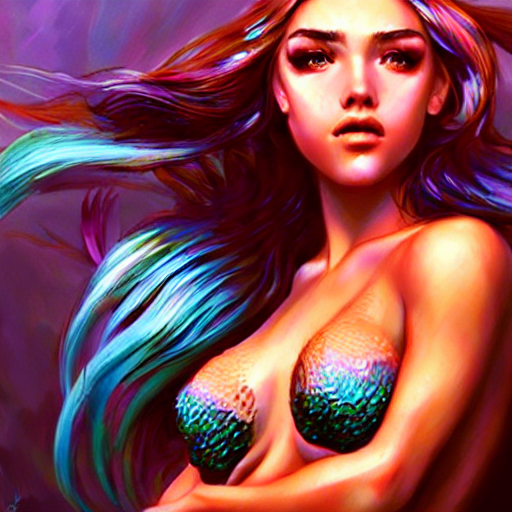

In [23]:
sample_path = "/content/drive/MyDrive/AI/StableDiffusion/samples"

#for steps in [10,25,50,75,100]:
for steps in [10,25,50]:
  #for cgs in [1,5,10,25,50,75,100]:
  for cgs in [150,200,250,300]:
    num_inference_steps=steps
    clip_loss_scale=cgs
    blue_loss_scale=clip_loss_scale/num_inference_steps
    img=doTheStuff()
    output.clear()
    print(cgs,steps)
    display.display(img)
    imgName="cgs_r3_%0.2f_%d.png"%(cgs,steps)
    imgPath=os.path.join(sample_path, imgName)
    img.save(imgPath)


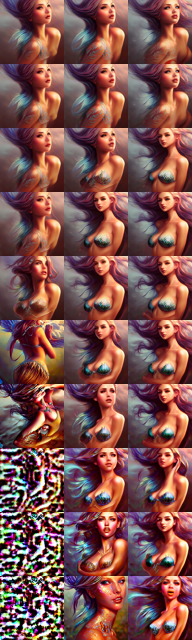

In [27]:
grid=Image.new("RGB",(64*3,64*10))
for i,steps in enumerate([10,25,50]):
  for j,cgs in enumerate([1,5,10,25,50,75,100,150,200,250,300]):
    imgName="cgs_r3_%0.2f_%d.png"%(cgs,steps)
    imgPath=os.path.join(sample_path, imgName)
    img=Image.open(imgPath).resize((64,64))
    grid.paste(img,(i*64,j*64))
  
grid
